In [ ]:
import numpy as np
import pandas as pd 
import re
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## Reading Dataset

In [ ]:
df_tr = pd.read_csv('../input/shai-training-2022-a-level-2/Train.csv')
df_val = pd.read_csv('../input/shai-training-2022-a-level-2/Valid.csv')

## EDA

In [6]:
# Training data
df_tr.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [7]:
print(df_tr.shape)
print(df_val.shape)

(40000, 2)
(5000, 2)


In [8]:
# View summary of our Dataset
print(df_tr.info())
print(df_val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB
None


In [9]:
# Check nulls
print(df_tr.isnull().sum())
print(df_val.isnull().sum())


text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [10]:
# summary stats for label
print(df_tr.describe())
print(df_val.describe())

              label
count  40000.000000
mean       0.499525
std        0.500006
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
             label
count  5000.000000
mean      0.502800
std       0.500042
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000


In [11]:
# Check value of each label in our dataset
print(df_tr['label'].value_counts())
print(df_val['label'].value_counts())

0    20019
1    19981
Name: label, dtype: int64
1    2514
0    2486
Name: label, dtype: int64


In [12]:
# Dataframes
df_s = [df_tr, df_val]

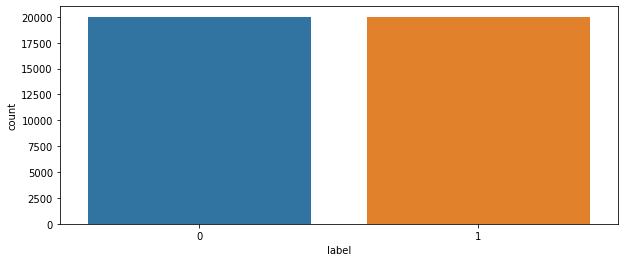

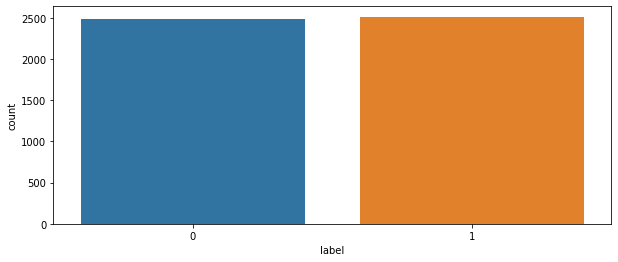

In [13]:
# Visualize labels [0,1]
for df in df_s:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df,x="label");

##### our data balanced!

## Data Cleaning

#### Define Cleaning Functions

In [14]:
# Remove Punctuations
def rmv_punc(txt):
    for c in string.punctuation:
        txt = txt.replace(c, '')
    return txt
# Remove Stopwords
def stwords(txt):
    return " ".join([w for w in str(txt).split() if w not in stopWords])

# Check Common words
def rmv_common(txt):
    cnt = Counter()
    for t in txt:
        for word in t.split():
            cnt[word] += 1
    # Remove Common words
    freqs = set([w for (w, wc) in cnt.most_common(10)])
    return " ".join([w for w in str(txt).split() if w not in freqs])
    
# Remove Rare words
def rmv_rare(txt):
    nonFreq = pd.Series(' '.join(txt).split()).value_counts()[-10:] # 10 rare words
    nonFreq = list(nonFreq.index)
    return " ".join([w for w in str(txt).split() if w not in nonFreq])

# Remove Emojis 
def emoji(txt):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', txt)

# Remove multi whitespace
multiple_space_re = re.compile("\s{2,}")
def rmv_multi_space(txt):
    return multiple_space_re.sub(repl=" ", string=txt)

# Remove Numbers
numbers_re = re.compile("\d+")
def remove_nums(txt):
    return numbers_re.sub(repl="", string=txt)

# Extra Cleaning step 'Remove repeated characters'
def remove_repeating_char(txt):
    return re.sub(r'(.)\1+', r'\1', txt)

In [15]:
def text_cleaning(txt):
    txt = txt.lower().strip()
    txt = rmv_punc(txt)
    txt = stwords(txt)
    txt = rmv_common(txt)
    txt = rmv_rare(txt)
    txt = emoji(txt) 
    txt = rmv_multi_space(txt)
    txt = remove_nums(txt)
    txt = remove_repeating_char(txt)
    return txt

In [16]:
df_tr['clean_text'] = df_tr['text'].apply(text_cleaning)

In [17]:
df_tr.head()

,text,label,clean_text
0,I grew up (b. 1965) watching and loving the Th...,0,grew b watching loving thunderbirds mates scho...
1,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sat coke chips expectatio...
2,Why do people who do not know what a particula...,0,people know particular time past like fel ned ...
3,Even though I have great interest in Biblical ...,0,even though great interest biblical movies bor...
4,Im a die hard Dads Army fan and nothing will e...,1,im die hard dads army fan nothing ever change ...


In [18]:
# apply text cleaning on our data validation 
df_val['clean_text'] = df_val['text'].apply(text_cleaning)

In [19]:
df_val.head()

,text,label,clean_text
0,It's been about 14 years since Sharon Stone aw...,0,years since sharon stone awarded viewers legc...
1,someone needed to make a car payment... this i...,0,someone neded make car payment truly awful mak...
2,The Guidelines state that a comment must conta...,0,guidelines state coment must contain minimum f...
3,This movie is a muddled mish-mash of clichés f...,0,movie mudled mishmash clichés recent cinema pr...
4,Before Stan Laurel became the smaller half of ...,0,stan laurel became smaler half altime greatest...


## Stemming 

In [23]:
# ! pip install texthero
# !pip install -U spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 48.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.2/806.2 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.0/490.0 kB 34.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.2
    Uninstalling catalogue-1.0.2:
      Successfully uninstalled catalogue-1.0.2
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.6
    Uninstalling srsly-1.0.6:
      Successfully uninstalled srsly-1.0.6
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.6
    Uninstalling thinc-7.4.6:
      Successfully uninstalled thinc-7.4.6
  Attempting uninstall: spacy
    Found existing installation: spacy 2.3.8
    Uninstalling s

In [24]:
# Stemming
import texthero as hero
df_tr['clean_text_stem'] = hero.stem(df_tr['clean_text'])
df_tr.head()

/opt/conda/lib/python3.7/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.3.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.4.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


,text,label,clean_text,clean_text_stem
0,I grew up (b. 1965) watching and loving the Th...,0,grew b watching loving thunderbirds mates scho...,grew b watch love thunderbird mate schol watch...
1,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sat coke chips expectatio...,put movi dvd player sat coke chip expect hope ...
2,Why do people who do not know what a particula...,0,people know particular time past like fel ned ...,peopl know particular time past like fel ned t...
3,Even though I have great interest in Biblical ...,0,even though great interest biblical movies bor...,even though great interest biblic movi bore de...
4,Im a die hard Dads Army fan and nothing will e...,1,im die hard dads army fan nothing ever change ...,im die hard dad armi fan noth ever chang got t...


In [25]:
# Stemming for Validation
df_val['clean_text_stem'] = hero.stem(df_val['clean_text'])
df_val.head()

,text,label,clean_text,clean_text_stem
0,It's been about 14 years since Sharon Stone aw...,0,years since sharon stone awarded viewers legc...,year sinc sharon stone award viewer legcros tw...
1,someone needed to make a car payment... this i...,0,someone neded make car payment truly awful mak...,someon nede make car payment truli aw make jea...
2,The Guidelines state that a comment must conta...,0,guidelines state coment must contain minimum f...,guidelin state coment must contain minimum fou...
3,This movie is a muddled mish-mash of clichés f...,0,movie mudled mishmash clichés recent cinema pr...,movi mudl mishmash cliché recent cinema promis...
4,Before Stan Laurel became the smaller half of ...,0,stan laurel became smaler half altime greatest...,stan laurel becam smaler half altim greatest c...


## Lemmatization

In [26]:
wl = WordNetLemmatizer()

In [27]:
def lemmatize(txt):
    txt = " ".join([wl.lemmatize(word) for word in txt.split() if word not in stopWords and word.isalpha()])
    return txt

In [30]:
# import nltk
# nltk.download('omw-1.4')

In [31]:
# apply Lemmatization
df_tr['clean_text_lema'] = df_tr['clean_text'].apply(lemmatize)

In [32]:
df_tr.head()

,text,label,clean_text,clean_text_stem,clean_text_lema
0,I grew up (b. 1965) watching and loving the Th...,0,grew b watching loving thunderbirds mates scho...,grew b watch love thunderbird mate schol watch...,grew b watching loving thunderbird mate schol ...
1,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sat coke chips expectatio...,put movi dvd player sat coke chip expect hope ...,put movie dvd player sat coke chip expectation...
2,Why do people who do not know what a particula...,0,people know particular time past like fel ned ...,peopl know particular time past like fel ned t...,people know particular time past like fel ned ...
3,Even though I have great interest in Biblical ...,0,even though great interest biblical movies bor...,even though great interest biblic movi bore de...,even though great interest biblical movie bore...
4,Im a die hard Dads Army fan and nothing will e...,1,im die hard dads army fan nothing ever change ...,im die hard dad armi fan noth ever chang got t...,im die hard dad army fan nothing ever change g...


In [33]:
# Apply Lemmatization on our data validation 
df_val['clean_text_lema'] = df_val['clean_text'].apply(lemmatize)

df_val.head()

,text,label,clean_text,clean_text_stem,clean_text_lema
0,It's been about 14 years since Sharon Stone aw...,0,years since sharon stone awarded viewers legc...,year sinc sharon stone award viewer legcros tw...,year since sharon stone awarded viewer legcros...
1,someone needed to make a car payment... this i...,0,someone neded make car payment truly awful mak...,someon nede make car payment truli aw make jea...,someone neded make car payment truly awful mak...
2,The Guidelines state that a comment must conta...,0,guidelines state coment must contain minimum f...,guidelin state coment must contain minimum fou...,guideline state coment must contain minimum fo...
3,This movie is a muddled mish-mash of clichés f...,0,movie mudled mishmash clichés recent cinema pr...,movi mudl mishmash cliché recent cinema promis...,movie mudled mishmash clichés recent cinema pr...
4,Before Stan Laurel became the smaller half of ...,0,stan laurel became smaler half altime greatest...,stan laurel becam smaler half altim greatest c...,stan laurel became smaler half altime greatest...


#### Some EDA On Training data

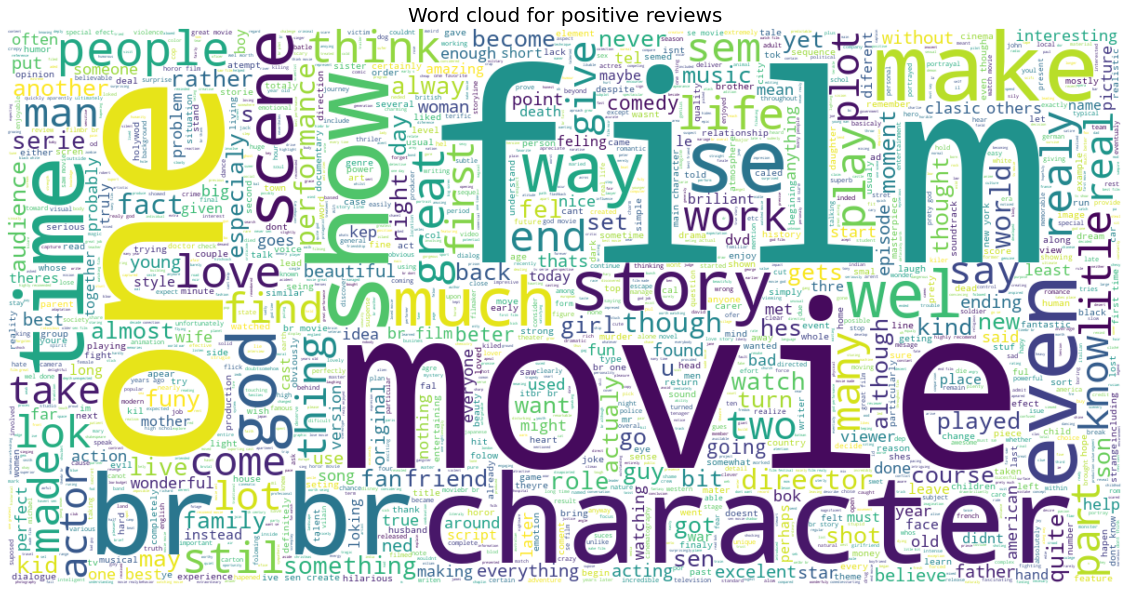

In [34]:
#word cloud for positive reviews in training data
positive_data = df_tr[df_tr.label == 1]['clean_text']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.show()

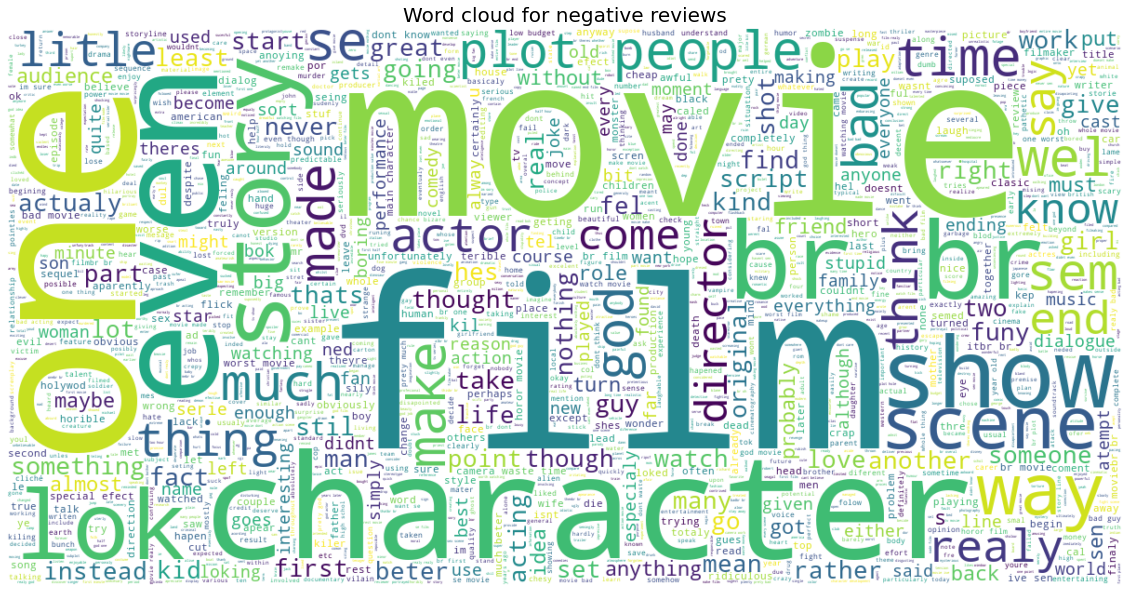

In [35]:
#word cloud for negative reviews in training data
negative_data = df_tr[df_tr.label == 0]['clean_text']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

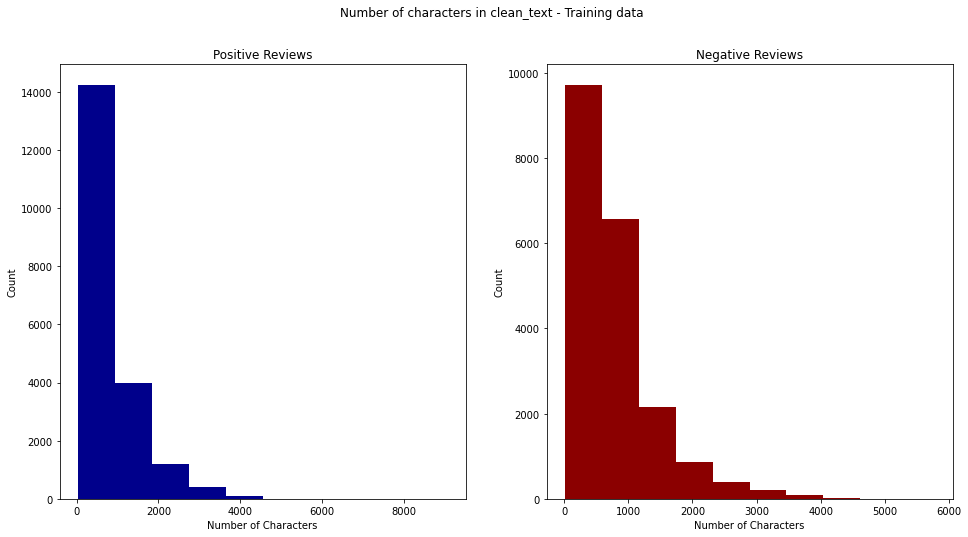

In [36]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='darkblue')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='darkred')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in clean_text - Training data')
plt.show()

We can see the number of **negative review** as char. number is largest vs. **positive review**

In [37]:
# Save our cleaned data
df_tr.to_csv("clean_tr.csv", index=False)
df_val.to_csv("clean_val.csv", index=False)